# Análisis de los descriptores WHIM

In [10]:
from __future__ import print_function
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pytraj as pyt

### Se carga la tabla de datos de la CDK2
**Se leen los datos con los ligandos y las etiquetas.** 

In [3]:
df_cdk2_labels = pd.read_json(r"./B_DATOS/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS.json")
df_cdk2_labels.head(5)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass,Labels_conf
1aq1,human cyclin dependent kinase 2 complexed with...,1997-11-12,1,A,2.00,298,92.953020,2,"[8, 13]","[[36, 43], [149, 161]]",1,['STU'],STU,440.0,inact_b
1b38,human cyclin-dependent kinase 2,1998-12-23,1,A,2.00,298,97.315436,1,[8],"[[36, 43]]",3,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a
1b39,human cyclin-dependent kinase 2 phosphorylated...,1998-12-23,1,A,2.10,298,97.315436,1,[8],"[[36, 43]]",3,"['ACE', 'ATP', 'MG']",ATP,398.0,inact_a
1buh,crystal structure of the human cdk2 kinase com...,1998-09-09,2,A,2.60,298,96.308725,2,"[7, 4]","[[40, 46], [295, 298]]",0,[],,,inact_a
1ckp,human cyclin dependent kinase 2 complexed with...,1999-01-13,1,A,2.05,298,93.624161,2,"[8, 11]","[[36, 43], [153, 163]]",2,"['EDO', 'PVB']",PVB,214.0,inact_a


**Se genera lista con los _paths_ de los archivos cocristalizados.** Los archivos *pdb* leidos fueron generados usando el programa **Reduce** de AmberTools.

In [4]:
import glob
path_crys_poses = "../ARCHIVOS/CRISTALES/LIGS_CDK2/LIGS_PREP_PDB_REDUCED/"
files_pose_crys = sorted( glob.glob(path_crys_poses + "*") )
print(F'Número de archivos de ligandos a cargar: {len(files_pose_crys)}')

Número de archivos de ligandos a cargar: 365


### Cargamos las moléculas con *rdkit*
Usamos el módulo **MolFromPDBFile** de redkit para cargar cada uno de los ligandos cocristalizados con la proteína. Para ello se crea un diccionario con los objetos correspondientes a cada molécula.

In [5]:
# Cargamos los archivos en un diccionario u
ligs_cdk2_dic = {file.split("/")[-1].split("_")[0]: Chem.MolFromPDBFile(file) for file in files_pose_crys}
# Cargamos los ids ordenados en una lista
pdb_lig_dic = {file.split("/")[-1].split("_")[0]: file.split("/")[-1].split("_")[1] for file in files_pose_crys}

#### Creamos un Dataframe a partir del diccionario
En este punto se crea un **Dataframe** que permita vincular cada objeto de rdkir con el nombre de la molécula, el PDB id al que pertenece y al archivo del ligando.

In [6]:
# Liasta de PDBIds y sus ligandos
df_pdb_ligs = pd.DataFrame.from_dict(pdb_lig_dic, orient='index', columns=["Lig"])
# Se añaden las rutas a losarchivos pdb
df_pdb_ligs["mol_rdk"] = ligs_cdk2_dic.values()
df_pdb_ligs["file"] = files_pose_crys
df_pdb_ligs["Labels_conf"] = df_cdk2_labels.loc[pdb_lig_dic.keys()].Labels_conf
# Visualizamos parte del dataframe
df_pdb_ligs.head(5)

,Lig,mol_rdk,file,Labels_conf
1aq1,STU,<rdkit.Chem.rdchem.Mol object at 0x7f8fa9a94df0>,../ARCHIVOS/CRISTALES/LIGS_CDK2/LIGS_PREP_PDB_...,inact_b
1b38,ATP,<rdkit.Chem.rdchem.Mol object at 0x7f8fa9a85030>,../ARCHIVOS/CRISTALES/LIGS_CDK2/LIGS_PREP_PDB_...,inact_a
1b39,ATP,<rdkit.Chem.rdchem.Mol object at 0x7f8fa9a85080>,../ARCHIVOS/CRISTALES/LIGS_CDK2/LIGS_PREP_PDB_...,inact_a
1ckp,PVB,<rdkit.Chem.rdchem.Mol object at 0x7f8fa9a85170>,../ARCHIVOS/CRISTALES/LIGS_CDK2/LIGS_PREP_PDB_...,inact_a
1di8,DTQ,<rdkit.Chem.rdchem.Mol object at 0x7f8fa9a85210>,../ARCHIVOS/CRISTALES/LIGS_CDK2/LIGS_PREP_PDB_...,inact_a


### Visualizamos las poses: Ejemplo ATP
Como ejemplo podemos hacer una búsqueda para elegir el número de conformaciones que poseen ATP.

In [7]:
print(F'Número de estructuras cristalográficas que poseen ATP: {len(df_pdb_ligs[df_pdb_ligs.Lig == "ATP"])}')

Número de estructuras cristalográficas que poseen ATP: 15


Importamos **nglview**, y para este ejemplo usamos los archivos *pdb* de los ligandos, aunque también es posible realizar la vizualización desde los objetos de rdkit. Pra este ejemplo seleccionamos las conformaciones de ATP en estructuras inactivas de CDK2.

In [11]:
import nglview
view = nglview.NGLWidget()
view.background = '#333333'
# Creamos una lista de moléculas a visualizar
list_viz = df_pdb_ligs.file[df_pdb_ligs.Lig == "ATP"][df_pdb_ligs.Labels_conf == "inact_a"]
# Leemos los archivos usando pytraj y los visualizamos con nglview
for lig in list_viz:
    stc_lig = pyt.load(lig)
    view.add_trajectory(stc_lig)
view

NGLWidget(background='#333333')

***
### Calculamos los descriptores WHIM para las moléculas
Creamos una **matriz donde cada fila corresponde a una molécula y las 114 características corresponden a las 114 propiedades** que calcula *rdkit*, las cuales son las mismas que calcula el software *Dragon*.

In [12]:
n_moleculas = len(df_pdb_ligs.index)
whim_array = np.empty((n_moleculas, 114))

for i, mol in enumerate(df_pdb_ligs.mol_rdk):
    whim_mol = Chem.rdMolDescriptors.CalcWHIM(mol)
    whim_array[i] = whim_mol

Esta  es las lista de descriptores que calcula *rdkit*.

In [13]:
whim_axial = ["L1u", "L2u", "L3u", "P1u", "P2u", "G1u", "G2u", "G3u", "E1u", "E2u", "E3u", 
               "L1m", "L2m", "L3m", "P1m", "P2m", "G1m", "G2m", "G3m", "E1m", "E2m", "E3m", 
               "L1v", "L2v", "L3v", "P1v", "P2v", "G1v", "G2v", "G3v", "E1v", "E2v", "E3v", 
               "L1e", "L2e", "L3e", "P1e", "P2e", "G1e", "G2e", "G3e", "E1e", "E2e", "E3e", 
               "L1p", "L2p", "L3p", "P1p", "P2p", "G1p", "G2p", "G3p", "E1p", "E2p", "E3p", 
               "L1i", "L2i", "L3i", "P1i", "P2i", "G1i", "G2i", "G3i", "E1i", "E2i", "E3i", 
               "L1s", "L2s", "L3s", "P1s", "P2s", "G1s", "G2s", "G3s", "E1s", "E2s", "E3s"]
whim_global = ["Tu", "Tm", "Tv", "Te", "Tp", "Ti", "Ts", 
               "Au", "Am", "Av", "Ae", "Ap", "Ai", "As", 
               "Gu", "Gm", 
               "Ku", "Km", "Kv", "Ke", "Kp", "Ki", "Ks", 
               "Du", "Dm", "Dv", "De", "Dp", "Di", "Ds", 
               "Vu", "Vm", "Vv", "Ve", "Vp", "Vi", "Vs"]

#### Creamos el DataFrame con las 365 moléculas y los 114 desciptores

In [14]:
df_whim = pd.DataFrame(whim_array, index = df_pdb_ligs.index)
df_whim.columns = whim_axial + whim_global

Visualizamos la matriz de correlación de los descriptores. Como puede observarse hay patrones de correlación entre los descriptores que se diferencian únicamente por los esquemas de peso usados.

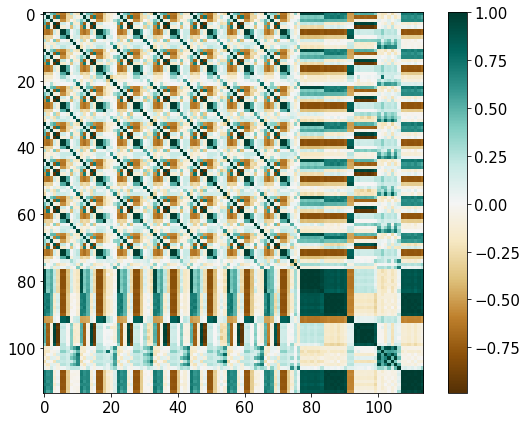

In [15]:
%matplotlib inline

fig = plt.figure(figsize=(9, 7))
plt.rcParams.update({'font.size': 15})
plt.imshow( df_whim.corr(), cmap='BrBG')
plt.colorbar();

***
### Selección de características
Importamos las librerías de **sklearn** que vamos a utilizar para hacer la selección de los descriptores finales.

In [16]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

In [17]:
#Estandarizamos
if False:
    scaler = StandardScaler()
    df_whim[df_whim.columns] = scaler.fit_transform(df_whim[df_whim.columns])

- **Eliminando características constantes o poco variables.**

In [18]:
#Eliminando características constantes
umbral_var = 0.001
constant_filter = VarianceThreshold(threshold = umbral_var)
constant_filter.fit( df_whim )
non_const_columns = df_whim.columns[constant_filter.get_support()]

print(F'Número de características a conservar: {len(non_const_columns)}\nSu varianza es mayor a {umbral_var}.')

Número de características a conservar: 98
Su varianza es mayor a 0.001.


In [19]:
df_whim_no_const = df_whim[non_const_columns]
df_whim_no_const.head(5)

,L1u,L2u,L3u,P1u,P2u,G3u,E1u,E2u,E3u,L1m,...,Dp,Di,Ds,Vu,Vm,Vv,Ve,Vp,Vi,Vs
1aq1,7.055,6.592,0.574,0.496,0.464,0.165,0.560,0.509,0.220,7.143,...,0.312,0.387,0.335,95.243,96.377,93.868,96.361,92.425,96.050,83.125
1b38,14.627,3.017,1.072,0.782,0.161,0.168,0.537,0.444,0.306,15.008,...,0.359,0.447,0.345,129.040,128.184,119.394,136.450,105.957,134.649,97.375
1b39,15.143,2.971,1.157,0.786,0.154,0.168,0.540,0.430,0.307,15.540,...,0.357,0.443,0.341,137.255,136.863,126.726,145.415,112.378,143.401,101.990
1ckp,9.851,1.338,0.323,0.856,0.116,0.193,0.581,0.507,0.451,10.938,...,0.590,0.502,0.418,32.549,40.035,33.804,33.414,35.072,32.473,29.241
1di8,13.308,3.023,0.010,0.814,0.185,0.186,0.536,0.379,0.298,13.525,...,0.343,0.417,0.338,57.162,59.616,55.138,59.596,52.744,58.066,47.071


In [ ]:
# Removiendo caracteristicas duplicadas
# Verificamos si hay columnas identicas
df_whim_no_const.T.duplicated().sum()

In [9]:
# Eliminando características correlacioneadas
correlated_features = set()
corr_mat_whim = df_whim_no_const.corr()

for row in range(len(corr_mat_whim)):
    for col in range(row):
        if abs(corr_mat_whim.iloc[row, col]) > 1:
            colname = corr_mat_whim.columns[row]
            correlated_features.add(colname)
len(correlated_features)

NameError: name 'df_whim_no_const' is not defined

In [473]:
#correlated_features

In [474]:
# Eliminamos las características con mayor correlación
df_whim_final = df_whim_no_const.drop(labels=correlated_features, axis=1)

In [475]:
df_whim_final.columns

Index(['L1u', 'L2u', 'L3u', 'P1u', 'P2u', 'G3u', 'E1u', 'E2u', 'E3u', 'L1m',
       'L2m', 'L3m', 'P1m', 'P2m', 'G3m', 'E1m', 'E2m', 'E3m', 'L1v', 'L2v',
       'L3v', 'P1v', 'P2v', 'G3v', 'E1v', 'E2v', 'E3v', 'L1e', 'L2e', 'L3e',
       'P1e', 'P2e', 'G3e', 'E1e', 'E2e', 'E3e', 'L1p', 'L2p', 'L3p', 'P1p',
       'P2p', 'G3p', 'E1p', 'E2p', 'E3p', 'L1i', 'L2i', 'L3i', 'P1i', 'P2i',
       'G3i', 'E1i', 'E2i', 'E3i', 'L1s', 'L2s', 'L3s', 'P1s', 'P2s', 'G3s',
       'E1s', 'E2s', 'E3s', 'Tu', 'Tm', 'Tv', 'Te', 'Tp', 'Ti', 'Ts', 'Au',
       'Am', 'Av', 'Ae', 'Ap', 'Ai', 'As', 'Ku', 'Km', 'Kv', 'Ke', 'Kp', 'Ki',
       'Ks', 'Du', 'Dm', 'Dv', 'De', 'Dp', 'Di', 'Ds', 'Vu', 'Vm', 'Vv', 'Ve',
       'Vp', 'Vi', 'Vs'],
      dtype='object')

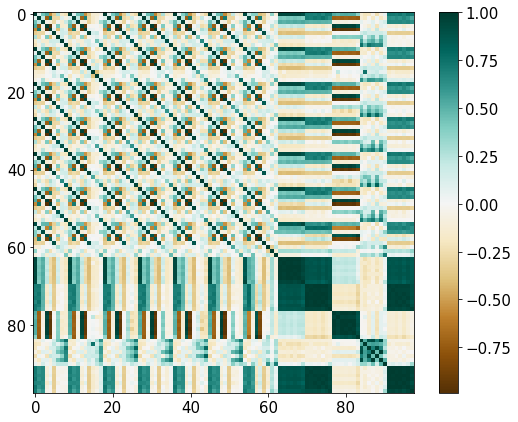

In [476]:
%matplotlib inline
# visualizamos la matriz D
fig = plt.figure(figsize=(9, 7))
plt.rcParams.update({'font.size': 15})
plt.imshow(df_whim_final.corr(), cmap='BrBG')
plt.colorbar();

#### Análisis de Componentes Principales

In [477]:
from sklearn.decomposition import PCA
from modulos.plotting_functions import plot_mds_or_pca, plot_anotation_labels

pca_whim = PCA(copy=True, n_components= 2).fit_transform( df_whim_final )

In [478]:
ligand_labels = ["red" if i else "none" for i in df_pdb_ligs.Lig == "ATP"]
len(ligand_labels)

365

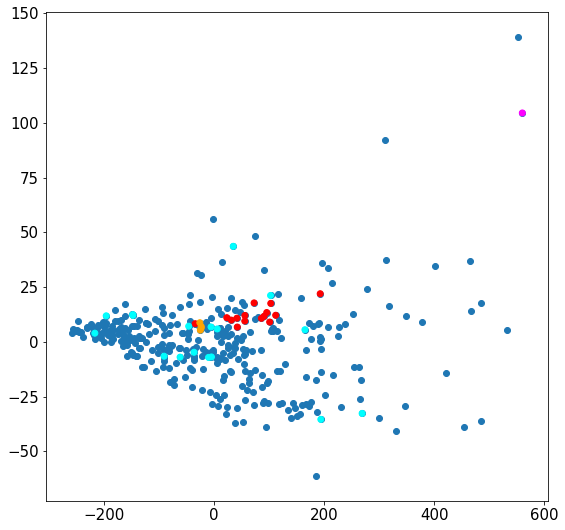

In [479]:
label_ATP = ["red" if i else "none" for i in df_pdb_ligs.Lig == "ATP"]
label_ADP = ["orange" if i else "none" for i in df_pdb_ligs.Lig == "ADP"]
label_STU = ["magenta" if i else "none" for i in df_pdb_ligs.index == "5a14"]

lista_csar = ["4ek4", "4ek5", "4fkg", "4fki", "4ek6", "4fjk", "4fkl", "4ek8", "3sw4", "3sw7", 
              "4fko", "4fkp", "4fkq", "4fkr", "4fks", "4fkt", "4fku", "4fkv", "4fkw"]
#lista_csar = ["4fku", "4fkw"]
label_csar = ["cyan" if i in lista_csar else "none" for i in df_pdb_ligs.index]

fig = plt.figure(figsize=(9, 9))
#plot_mds_or_pca(mds = pca_whim.T, alpha = 0.8, colors_list=ligand_labels, general_font_size= 20)
plt.scatter(pca_whim.T[0], pca_whim.T[1])
plt.scatter(pca_whim.T[0], pca_whim.T[1], color=label_ATP)
plt.scatter(pca_whim.T[0], pca_whim.T[1], color=label_csar)
plt.scatter(pca_whim.T[0], pca_whim.T[1], color=label_ADP)
plt.scatter(pca_whim.T[0], pca_whim.T[1], color=label_STU);


In [482]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components= 2, n_neighbors=10).fit_transform( df_whim_final )

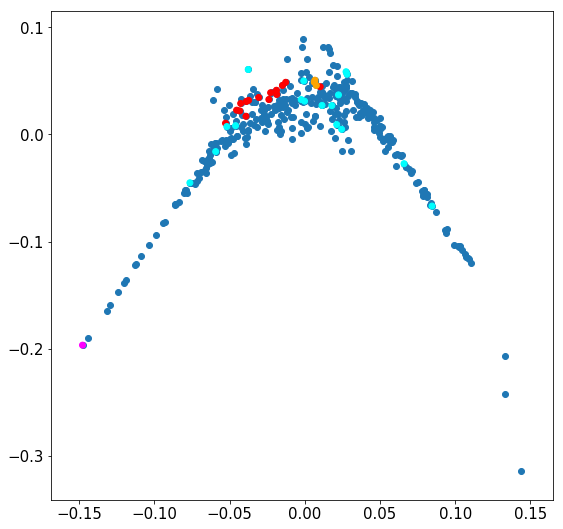

In [483]:
fig = plt.figure(figsize=(9, 9))
#plot_mds_or_pca(mds = pca_whim.T, alpha = 0.8, colors_list=ligand_labels, general_font_size= 20)
plt.scatter(lle[:,0], lle[:,1])
plt.scatter(lle[:,0], lle[:,1], color=label_ATP)
plt.scatter(lle[:,0], lle[:,1], color=label_ADP)
plt.scatter(lle[:,0], lle[:,1], color=label_csar)
plt.scatter(lle[:,0], lle[:,1], color=label_STU);


In [95]:
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
whim_final = scaler.fit_transform(df_whim_final)
D = distance_matrix(whim_final, whim_final)

In [96]:
from scipy.spatial.distance import euclidean
import scipy

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
whim_final = scaler.fit_transform(df_whim_final)

leng = whim_final.shape[0]
D = scipy.zeros([leng,leng])
for i in range(leng):
    for j in range(leng):
        D[i,j] = euclidean(whim_final[i], whim_final[j])

In [97]:
D.shape

(365, 365)

In [98]:
from modulos.MDS import cMDS
mds = cMDS(D)

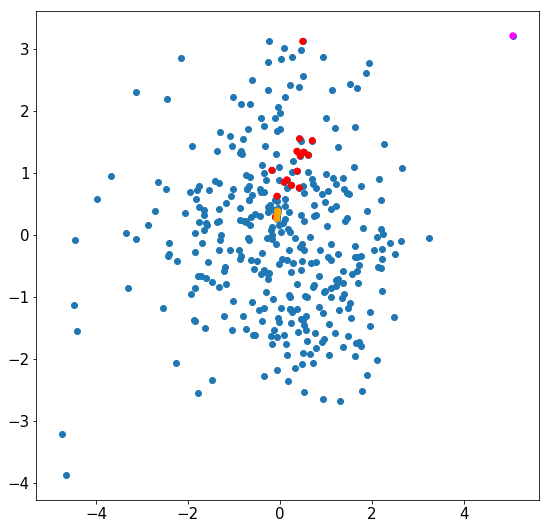

In [99]:
fig = plt.figure(figsize=(9, 9))
plt.scatter(mds[0][0], mds[0][1])
plt.scatter(mds[0][0], mds[0][1], color=label_ATP)
plt.scatter(mds[0][0], mds[0][1], color=label_ADP)
plt.scatter(mds[0][0], mds[0][1], color=label_STU)